# Does Stretching Pulses Amplify Noise? (2)
Testing this on a sample 

In [1]:
from qiskit import *
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_london')
from qiskit.test.mock import FakeValencia
fake_backend = FakeValencia()

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\providers\ibmq\ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


In [2]:
import numpy as np
from qiskit.pulse import DriveChannel
from qiskit.compiler import assemble
from qiskit.qobj.utils import MeasLevel, MeasReturnType

# The pulse simulator
from qiskit.providers.aer import PulseSimulator
simulator= PulseSimulator()

# Object for representing physical models
from qiskit.providers.aer.pulse import PulseSystemModel


In [3]:
# set the drive strength
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad0'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad1'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad2'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad3'] = 63455017.85
getattr(fake_backend.configuration(), 'hamiltonian')['vars']['omegad4'] = 63455017.85

backend = fake_backend
backend_model = PulseSystemModel.from_backend(backend)

# set the qubit frequency
freq_est = 4.97e9
fake_backend.defaults().qubit_freq_est = [freq_est]
#getattr(fake_backend.configuration(), 'hamiltonian')['vars']['wq0'] = 2*np.pi*freq_est

In [4]:
simulator.configuration()

In [5]:
fake_backend.configuration()

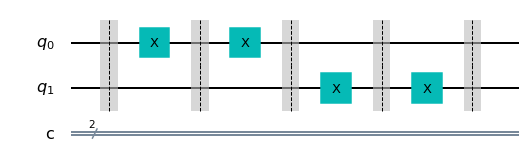

In [6]:
circ = QuantumCircuit(2,2)
circ.barrier(0,1)
circ.x(0)
circ.barrier(0,1)
circ.x(0)
circ.barrier(0,1)
circ.x(1)
circ.barrier(0,1)
circ.x(1)
circ.barrier(0,1)
# circ.measure(0,0)
# circ.measure(0,1)
circ.draw(output = 'mpl')

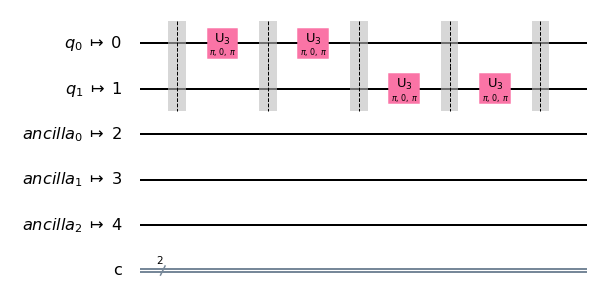

In [7]:

from qiskit.compiler import transpile
circ_device = transpile(circ, fake_backend)
circ_device.draw(output = 'mpl')

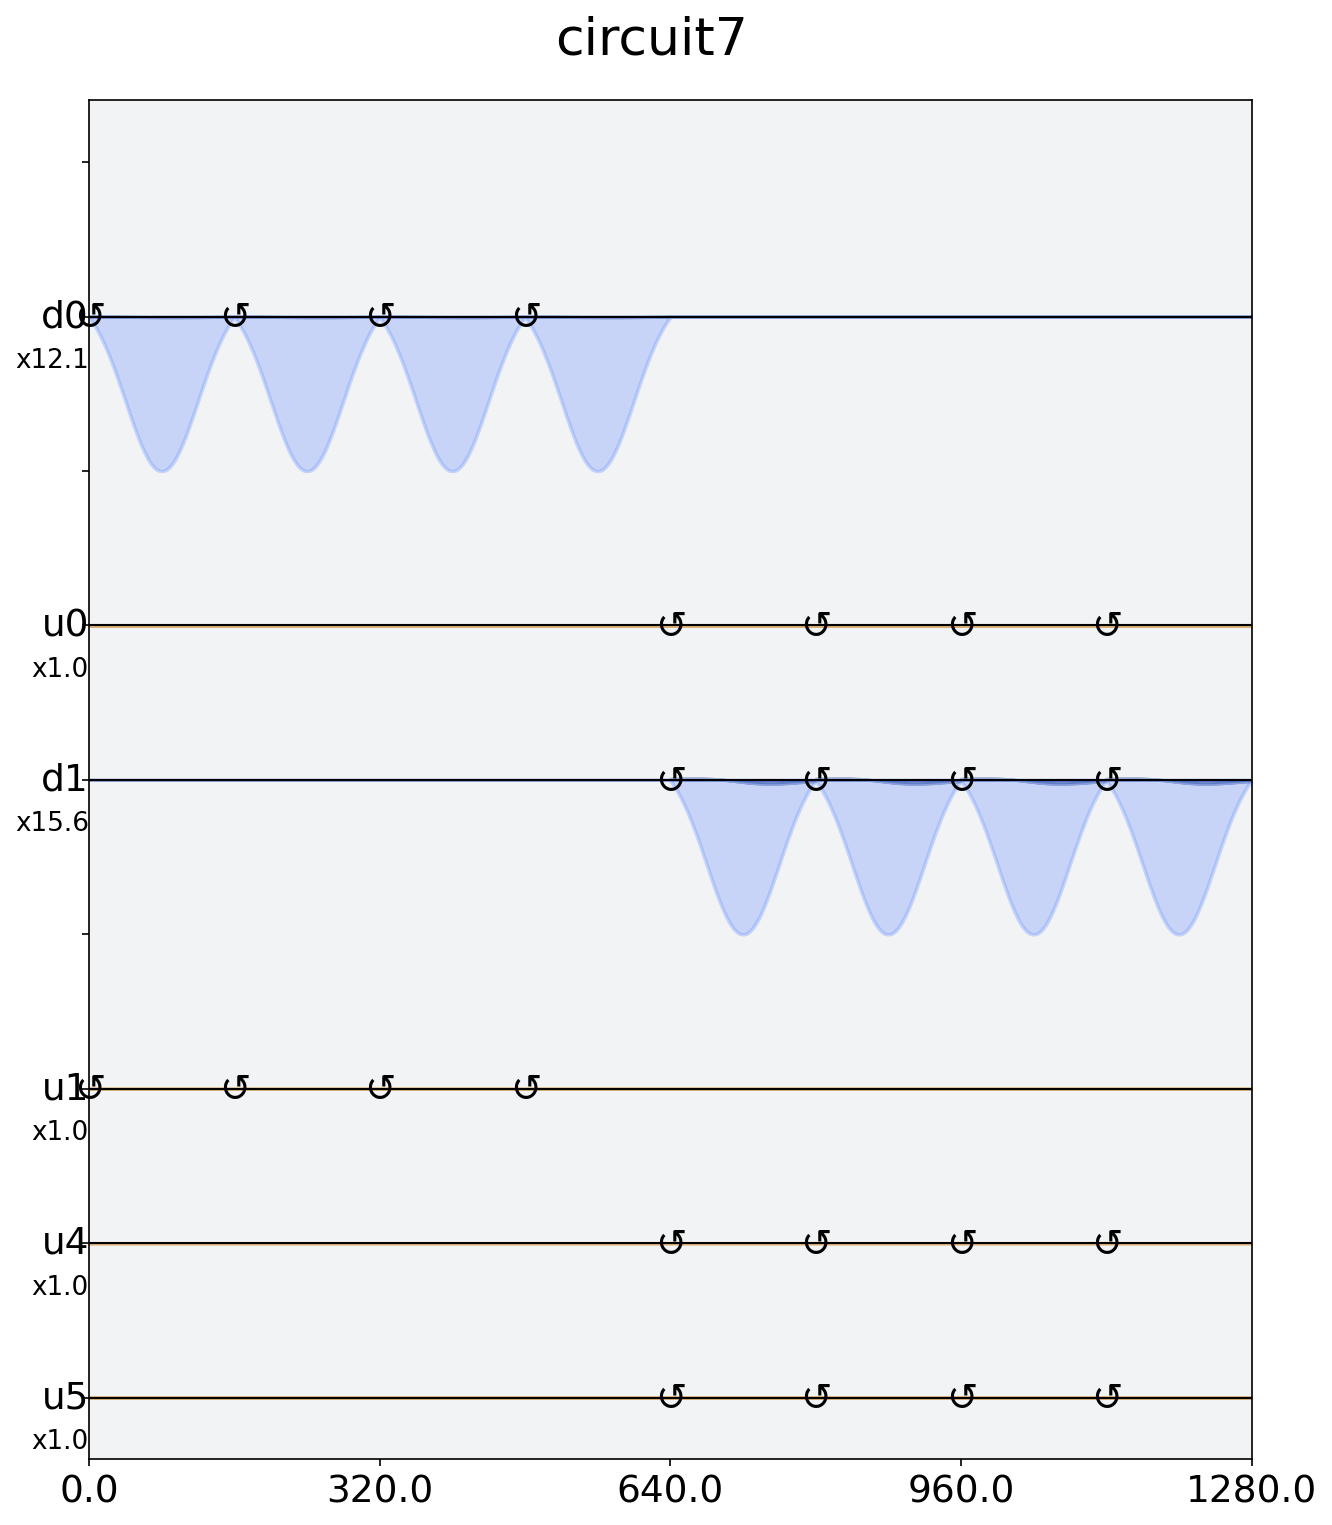

In [8]:
from qiskit.compiler import schedule 
sched_circ = schedule(circ_device, fake_backend)
sched_circ.draw()

In [9]:
sched_circ.instructions

((0, ShiftPhase(-3.141592653589793, DriveChannel(0))),
 (0, ShiftPhase(-3.141592653589793, ControlChannel(1))),
 (0,
  Play(Waveform(array([0.00064311-3.87457367e-05j, 0.00131035-3.75102863e-05j,
         0.00200228-3.61946877e-05j, 0.00271923-3.47956156e-05j,
         0.00346152-3.33097196e-05j, 0.00422944-3.17336526e-05j,
         0.00502324-3.00640677e-05j, 0.00584311-2.82976107e-05j,
         0.00668924-2.64309638e-05j, 0.00756174-2.44608491e-05j,
         0.00846071-2.23840070e-05j, 0.00938617-2.01972580e-05j,
         0.01033811-1.78974806e-05j, 0.01131646-1.54816298e-05j,
         0.01232111-1.29467626e-05j, 0.01335188-1.02900558e-05j,
         0.01440854-7.50878462e-06j, 0.01549079-4.60036972e-06j,
         0.0165983 -1.56241003e-06j, 0.01773063+1.60736818e-06j,
         0.01888732+4.91103128e-06j, 0.02006783+8.35047103e-06j,
         0.02127154+1.19273463e-05j, 0.02249778+1.56431051e-05j,
         0.0237458 +1.94989334e-05j, 0.0250148 +2.34957915e-05j,
         0.0263039 +2.76

In [10]:
from qiskit.pulse.instructions import ShiftPhase

isinstance(sched_circ.instructions[0][1], ShiftPhase)

True

In [11]:
sched_circ.instructions[7][1].channels[0]

DriveChannel(0)

In [12]:
from qiskit.scheduler import measure
from qiskit.pulse.instructions import Play

def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr

def stretchSchedule(sched, factor):
    # args:circuit in pulse form WITHOUT measurement, stretch factor
    #output: pulses stretched by thefactor
    
    instrucs = sched.instructions
    new_sched = pulse.Schedule(name = "Schedule stretched by factor " + str(factor))
    
    #Only stretching the sample pulse, doing nothing to shiftphase, measurement,etc.
    
    for instruc_paren in instrucs:
        instruc = instruc_paren[1]
        #if sample pulse
        if (isinstance(instruc, Play)):
            
            stretched_samples = stretchSamples(instruc.pulse.samples, factor)
            channel = instruc.channels[0]
            new_sched+= pulse.Play(pulse.SamplePulse(stretched_samples), channel)
        #otherwise
        else:
            new_sched+= instruc
    
    #adding measurement
    new_sched +=measure([0,1], backend) <<new_sched.duration   #([0], backend)
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))
    

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\sample_pulse.py:44: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  "Waveform(samples, channel).", DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\sample_pulse.py:44: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  "Waveform(samples, channel).", DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\sample_pulse.py:44: DeprecationWarning: SamplePulse has been renamed to Waveform and is deprecated. Please replace SamplePulse(samples, channel) with Waveform(samples, channel).
  "Waveform(samples, channel).", DeprecationWarning)
C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\pulse\library\sample_pulse.py:44: Depreca

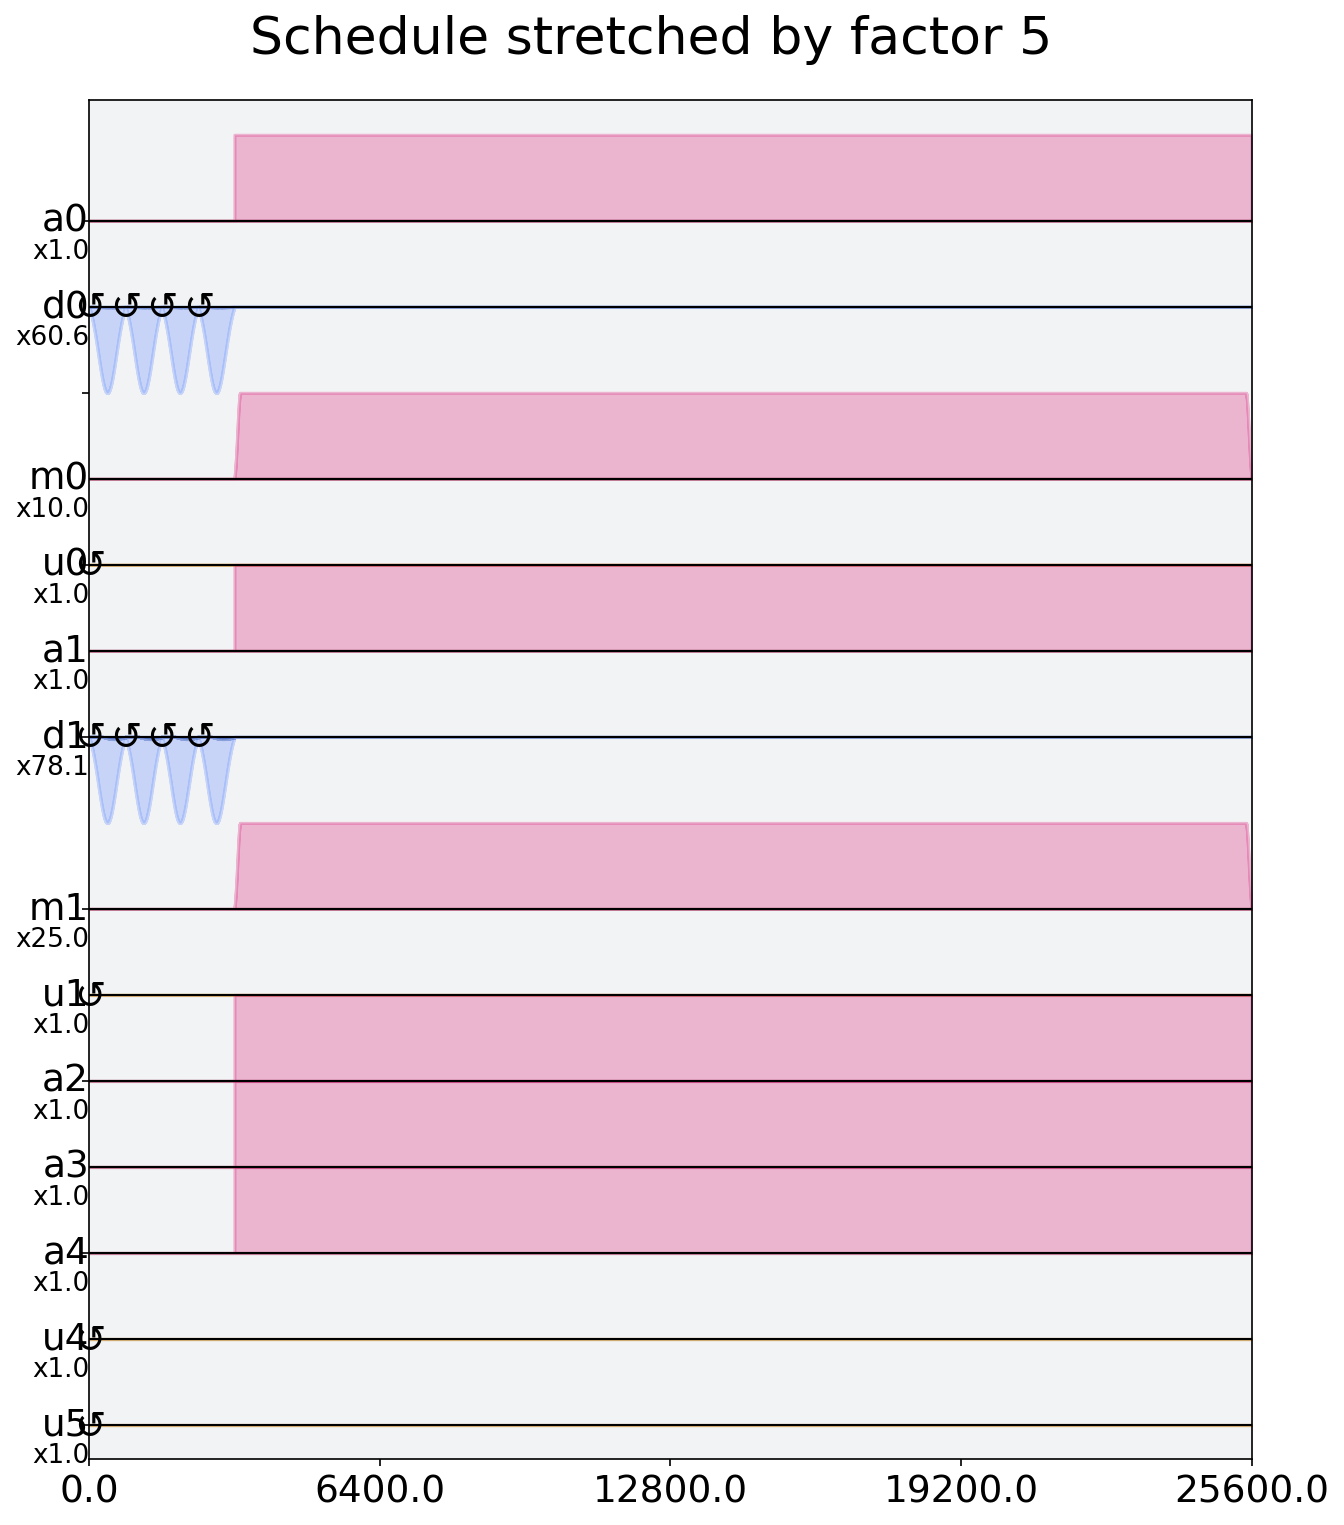

In [13]:
scaled_schedules[4].draw()

In [14]:
backend_sim = PulseSimulator()

# function for constructing duffing models
from qiskit.providers.aer.pulse import duffing_system_model

# cutoff dimension
dim_oscillators = 3

# frequencies for transmon drift terms, harmonic term and anharmonic term
# Number of oscillators in the model is determined from len(oscillator_freqs)
oscillator_freqs = [5.0e9, 5.2e9]
anharm_freqs = [-0.33e9, -0.33e9]

# drive strengths
drive_strengths = [0.02e9, 0.02e9]

# specify coupling as a dictionary (qubits 0 and 1 are coupled with a coefficient 0.002e9)
coupling_dict = {(0,1): 0.002e9}

# sample duration for pulse instructions 
dt = 1e-9

# create the model
two_qubit_model = duffing_system_model(dim_oscillators=dim_oscillators,
                                       oscillator_freqs=oscillator_freqs,
                                       anharm_freqs=anharm_freqs,
                                       drive_strengths=drive_strengths,
                                       coupling_dict=coupling_dict,
                                       dt=dt)

obj = assemble(scaled_schedules,
                     backend=backend_sim,
                     meas_level=1,
                     meas_return='avg',
                     shots=512)

sim_result = backend_sim.run(obj, two_qubit_model).result()

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\qiskit\compiler\assemble.py:323: RuntimeWarning: Dynamic rep rates not supported on this backend. rep_time will be used instead of rep_delay.
  RuntimeWarning,


ValueError: Channel u4 is not in Hamiltonian model

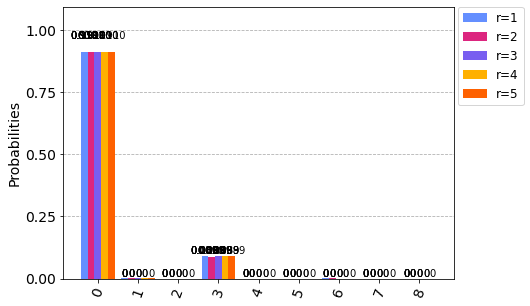

In [110]:
from qiskit.visualization import plot_histogram
results=[]
for i in range(5): 
    results.append(sim_result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

In [5]:
def stretchSamples(arr, scale):
    new_arr =[]
    for i in range(len(arr)):
        #shortening the height
        a = arr[i]/scale
        #extending the width
        for i in range(scale):
            new_arr.append(a)
    return new_arr

In [6]:
new_sched = pulse.Schedule(name = "stretching the X gate")
#adding phase shift 
new_sched+=sched_circ.instructions[0][1]


In [7]:
new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(sched_circ.instructions[1][1].pulse.samples)), pulse.DriveChannel(0))

In [8]:
new_sched+= sched_circ.instructions[2][1]

In [9]:
new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(sched_circ.instructions[3][1].pulse.samples)), pulse.DriveChannel(0))

In [10]:
new_sched+= sched_circ.instructions[4][1]

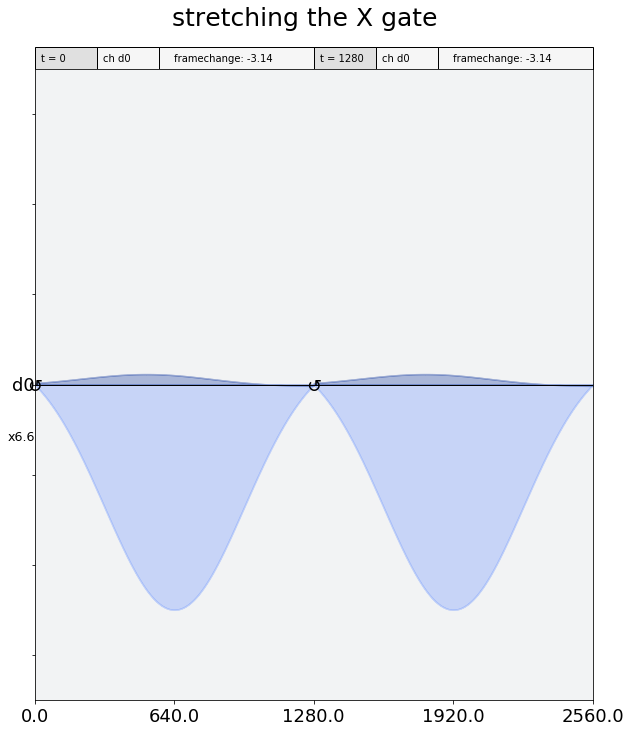

In [72]:
new_sched.draw()

# Stretching X

In [11]:
from qiskit.scheduler import measure
def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr
def stretchSchedule(sched, factor):
    # args:circuit in pulse form, stretch factor
    #output: pulses stretched by thefactor
    instruc = sched.instructions
    new_sched = pulse.Schedule(name = "stretching the X gate")
    #adding phase shift 
    new_sched+=instruc[0][1]
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[1][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=instruc[2][1]
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[3][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=instruc[4][1]
    new_sched +=measure([0], backend) <<new_sched.duration
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))
    

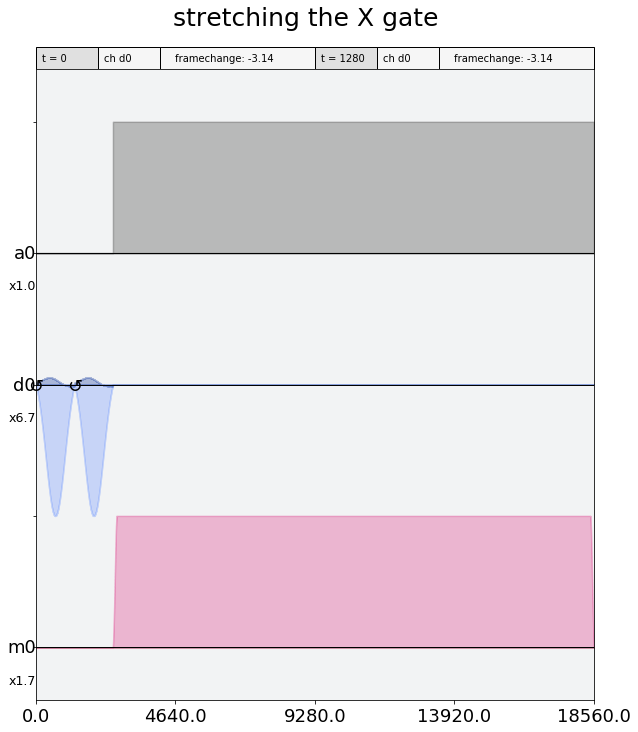

In [12]:
scaled_schedules[1].draw()

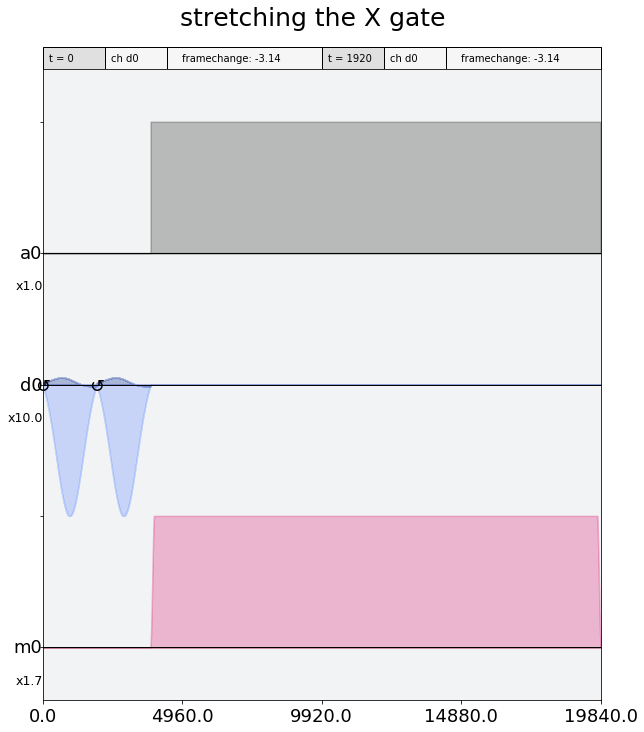

In [13]:
scaled_schedules[2].draw()

In [17]:
job = execute(scaled_schedules, backend, shots = 2048, meas_level=2 )

In [18]:
result = job.result(timeout=120)
scale_factor = 1e-14
def baseline_remove(values):
    return np.array(values) - np.mean(values)


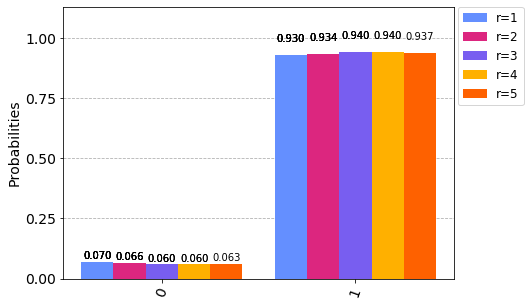

In [19]:
from qiskit.visualization import plot_histogram
results=[]
for i in range(5): 
    results.append(result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

## Applying Measurement Error Mitigation

In [23]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal,CompleteMeasFitter)
from qiskit.tools.monitor import job_monitor

qr = qiskit.QuantumRegister(1)

cal_circuits, state_labels = complete_meas_cal(qr=qr, 
                                               circlabel='measurement_calibration')

cal_job = execute(cal_circuits,
             backend=backend,
             shots=8192,
             optimization_level=0)
#print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

Job Status: job has successfully run


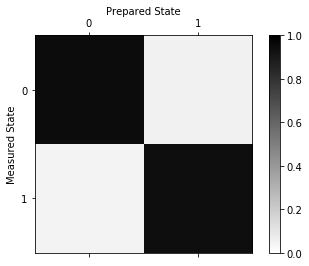

In [24]:

#making a filter
meas_fitter = CompleteMeasFitter(cal_results, state_labels)
meas_filter = meas_fitter.filter
meas_fitter.plot_calibration()

In [25]:
mitigated_result = meas_filter.apply(result)

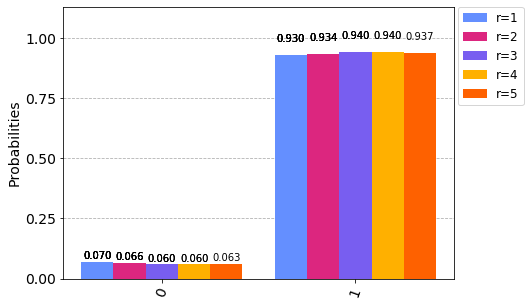

In [26]:
from qiskit.visualization import plot_histogram
mit_results=[]
for i in range(5): 
    mit_results.append(mitigated_result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

# Stretching XX

In [27]:
circ = QuantumCircuit(1,1)

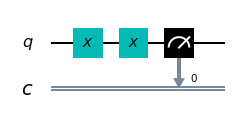

In [28]:
circ.x(0)
circ.x(0)
circ.measure(0,0)
circ.draw(output = 'mpl')

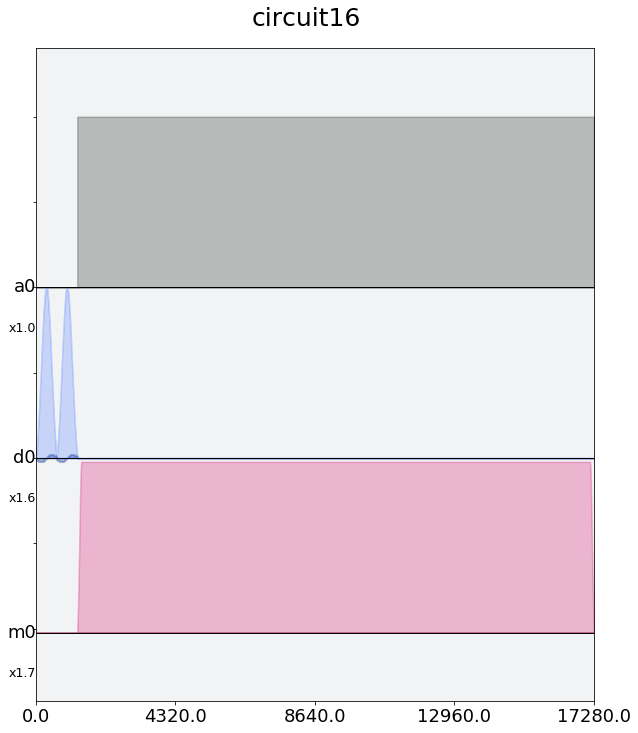

In [29]:
circ_trans = transpile(circ, backend)
sched_circ = schedule(circ, backend)
sched_circ.draw()

In [30]:
sched_circ.timeslots

{DriveChannel(0): [(0, 640), (640, 1280)],
 MeasureChannel(0): [(1280, 17280)],
 AcquireChannel(0): [(1280, 17280)],
 MemorySlot(0): [(1280, 17280)]}

In [31]:
sched_circ.instructions

((0,
  Play(SamplePulse(array([0.00121178-5.99530526e-03j, 0.00243494-6.05147984e-03j,
         0.00366953-6.10788213e-03j, 0.0049156 -6.16450794e-03j,
         0.00617319-6.22135354e-03j, 0.00744234-6.27841521e-03j,
         0.00872311-6.33568875e-03j, 0.01001552-6.39316952e-03j,
         0.01131963-6.45085424e-03j, 0.01263548-6.50873780e-03j,
         0.01396309-6.56681601e-03j, 0.01530252-6.62508467e-03j,
         0.01665381-6.68353913e-03j, 0.01801698-6.74217474e-03j,
         0.01939208-6.80098636e-03j, 0.02077913-6.85996981e-03j,
         0.02217818-6.91911951e-03j, 0.02358926-6.97843125e-03j,
         0.0250124 -7.03789946e-03j, 0.02644763-7.09751947e-03j,
         0.02789499-7.15728523e-03j, 0.02935449-7.21719209e-03j,
         0.03082617-7.27723399e-03j, 0.03231006-7.33740628e-03j,
         0.03380619-7.39770290e-03j, 0.03531456-7.45811826e-03j,
         0.03683522-7.51864677e-03j, 0.03836818-7.57928193e-03j,
         0.03991346-7.64001906e-03j, 0.04147109-7.70085072e-03j,
   

In [32]:
from qiskit.scheduler import measure
def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr
def stretchSchedule(sched, factor):
    # args:circuit in pulse form, stretch factor
    #output: pulses stretched by thefactor
    instruc = sched.instructions
    new_sched = pulse.Schedule(name = "stretching the XX gate")
    #adding phase shift 
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[0][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[1][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched +=measure([0], backend) <<new_sched.duration
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))

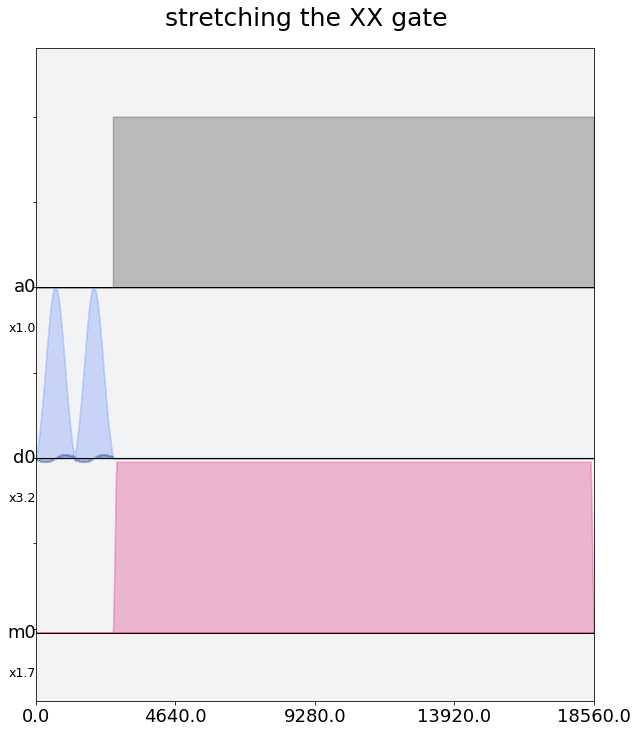

In [33]:
scaled_schedules[1].draw()

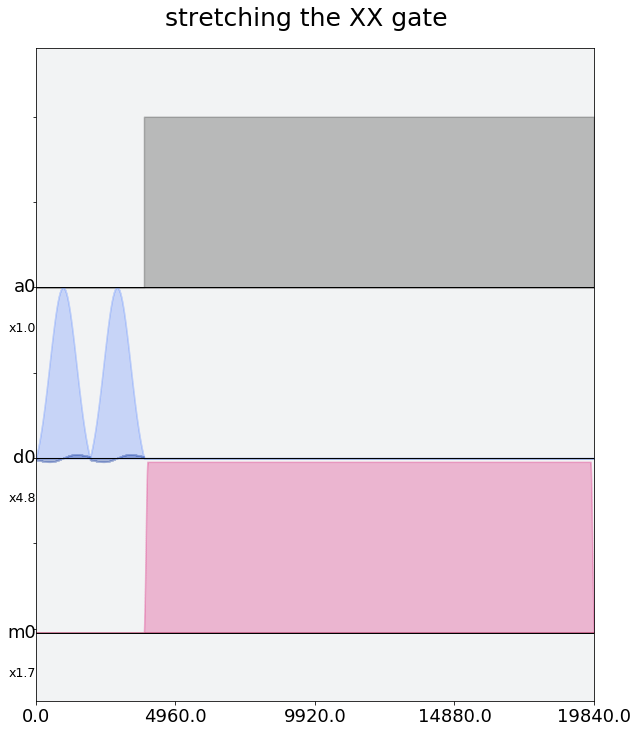

In [34]:
scaled_schedules[2].draw()

In [35]:
job = execute(scaled_schedules, backend, shots = 2048, meas_level=2 )
result = job.result(timeout=120)
scale_factor = 1e-14
def baseline_remove(values):
    return np.array(values) - np.mean(values)


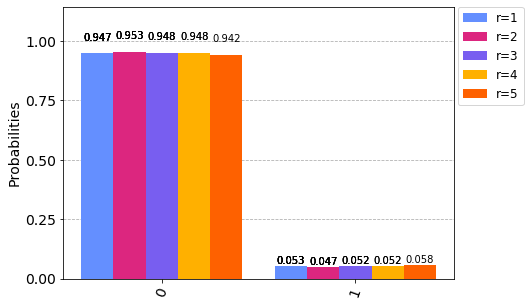

In [36]:
from qiskit.visualization import plot_histogram
results=[]
for i in range(5): 
    results.append(result.get_counts(i))
plot_histogram(results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

### Applying Measurement Error Mitigation

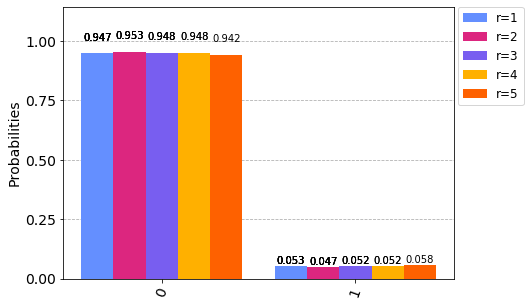

In [37]:
mitigated_result = meas_filter.apply(result)
mit_results=[]
for i in range(5): 
    mit_results.append(result.get_counts(i))
plot_histogram(mit_results, legend = ['r=1', 'r=2', 'r=3', 'r=4', 'r=5'])

# Analysis
Stretching one or 2 pauli gates does not really make a difference, if they are the only gates in the circuit. Need to make larger circuits and stretch the single qubit gates in them

# Stretching Arbitrary number of XX's

In [39]:
# Stretching gates with factors 

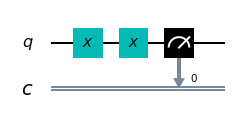

In [40]:
circ.draw(output='mpl')

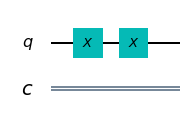

In [41]:
circ = QuantumCircuit(1,1)
circ.x(0)
circ.x(0)
circ.draw(output='mpl')

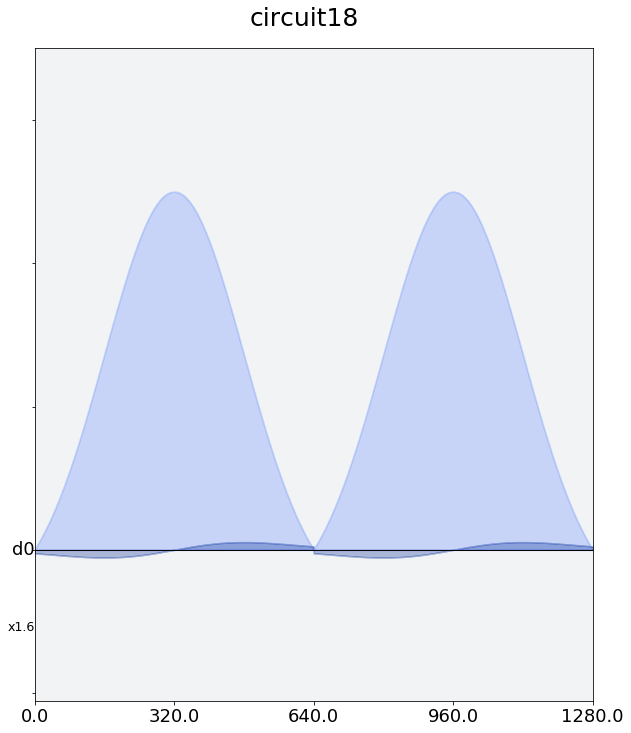

In [42]:
circ_trans = transpile(circ, backend)
sched_circ = schedule(circ, backend)
sched_circ.draw()

In [43]:
sched_one = sched_circ.append(sched_circ)

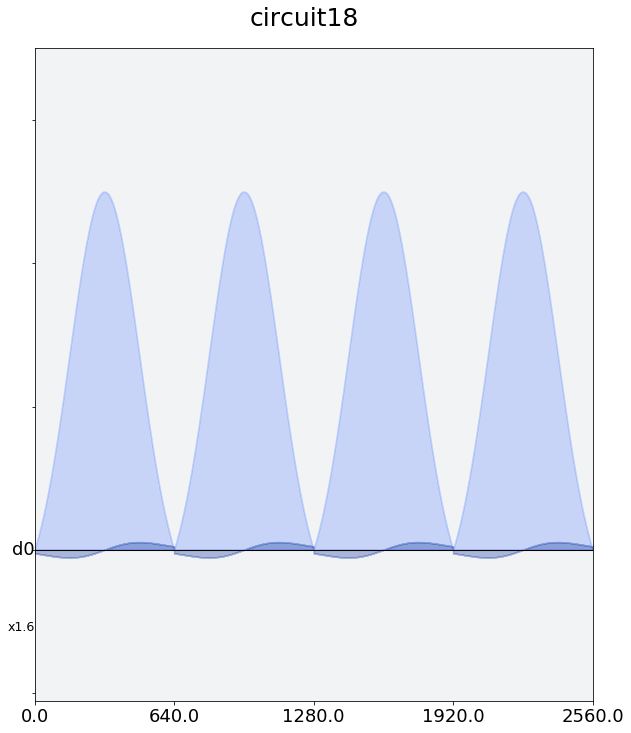

In [44]:
sched_one.draw()

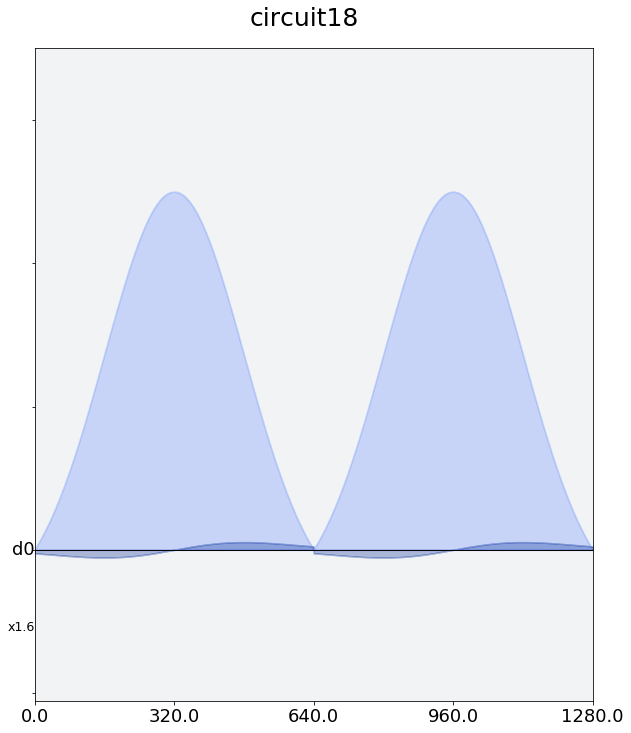

In [45]:
sched_circ.draw()

In [46]:
scaled_circ = []

def stretchSamples(arr, factor):
    #args: array of samples
    #output: stretched array
    new_arr =[]
    for i in range(len(arr)):
        a = arr[i]/factor
        #flattening by fatcor
        for i in range(factor):
            new_arr.append(a)
    return new_arr
def stretchSchedule(sched, factor):
    # args:circuit in pulse form, stretch factor
    #output: pulses stretched by thefactor
    instruc = sched.instructions
    new_sched = pulse.Schedule(name = "stretching the XX gate")
    #adding phase shift 
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[0][1].pulse.samples, factor)), pulse.DriveChannel(0))
    new_sched+=pulse.Play(pulse.SamplePulse(stretchSamples(instruc[1][1].pulse.samples, factor)), pulse.DriveChannel(0))
    return new_sched
#now making the scaled schedule
scaled_schedules = []
for i in range(5):
    scaled_schedules.append(stretchSchedule(sched_circ, i+1))

In [47]:
#varying gates and schedules 
circ_gates = []

for circus in scaled_schedules:
    #varying XXs
    #1
    circy = circus
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circus)
    
    #10
    circy = circus
    for i in range(4): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #20
    circy = circus
    for i in range(9): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #50
    circy = circus
    for i in range(24): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #80
    circy = circus
    for i in range(39): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #100
    circy = circus
    for i in range(49): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)
    #200
    circy = circus
    for i in range(99): 
        circy = circy.append(circus)
    circy +=measure([0], backend) <<circy.duration
    circ_gates.append(circy)


    

In [48]:
len(circ_gates)

35

In [49]:
job = execute(circ_gates, backend, shots = 8192, meas_level=2 )
job_monitor(job)



Job Status: job has successfully run


In [50]:
results = job.result(timeout = 120)

In [53]:
def get_prob(counts, k): 
    probs = []
    for i in range(7): 
        probs = probs + [((counts[k+i]['0'])/8192)]
    return probs
        


counts =[]
for i in range(35): 
    counts.append(results.get_counts(i))
scalings =[]
for i in range(5): 
    scalings.append([])
for i in range(5): 
    k = 7*i
    scalings[i] = get_prob(counts, k)


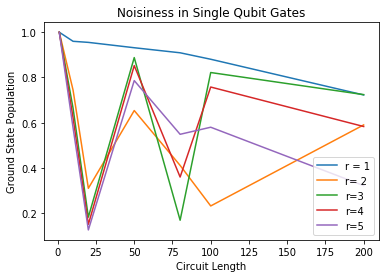

In [55]:
import matplotlib.pyplot as plt
num_gates = [1, 10, 20, 50 ,80,  100, 200]
distances=num_gates
plt.plot(distances, scalings[0], label="r = 1")
plt.plot(distances, scalings[1], label="r= 2")
plt.plot(distances, scalings[2], label="r=3")
plt.plot(distances, scalings[3], label="r=4")
plt.plot(distances, scalings[4], label="r=5")

plt.xlabel('Circuit Length')
plt.ylabel('Ground State Population')
plt.title('Noisiness in Single Qubit Gates')
plt.legend()
plt.show()

## Performing Linear Extrapolation using Curve Fitting

C:\Users\Eesh Gupta\anacondaaa\lib\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


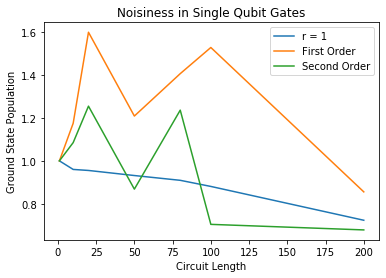

In [58]:
import numpy as np
from scipy.optimize import curve_fit
# extrapolating to 4 orders the entire thing through curve fitting 
orders = []
plot = []
for i in range(2,6): 
    #building up orders through curve fitting 
    some_order = []
    for k in range(len(num_gates)):
        plot=[]
        x = np.array([])
        y = np.array([])
        for c in range(i):
            x = np.append(x, c+1)
            y = np.append(y, scalings[c][k])
        plot.append(x)
        plot.append(y)
        def fit_func(x, a, b):
            return a*x + b
        params = curve_fit(fit_func, x, y)
        [a, b] = params[0]
        plot.append([a, b])
        some_order.append(params[0][1])
    orders.append(some_order)
#plotting the order curves 
num_gates = [1, 10, 20, 50 ,80,  100, 200]
distances=num_gates
plt.plot(distances, scalings[0], label="r = 1")
plt.plot(distances, orders[0], label="First Order")
plt.plot(distances, orders[1], label="Second Order")
#plt.plot(distances, scalings[3], label="r=4")
#plt.plot(distances, scalings[4], label="r=5")   

plt.xlabel('Circuit Length')
plt.ylabel('Ground State Population')
plt.title('Noisiness in Single Qubit Gates')
plt.legend()
plt.show()

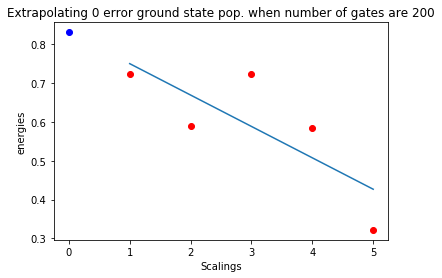

In [61]:
plt.plot(plot[0], plot[1], 'ro')
plt.plot(0, orders[3][6], 'bo')
plt.plot(x, plot[2][0]*x + plot[2][1])
plt.xlabel('Scalings')
plt.ylabel('energies')
plt.title('Extrapolating 0 error ground state pop. when number of gates are 200')
plt.show()